In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn import preprocessing , model_selection, metrics

In [2]:
#data to use in model 
datapath = "//home//nlpsomnath//NegNews/zackc//Misc Notebooks//Python Misc//Data//SentDF.pickle"
Data = pd.read_pickle(datapath)
target = 'LegalAction'
#(',').join(list(data))a

In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170584 entries, 0 to 1229029
Data columns (total 17 columns):
date                  170563 non-null object
entity                170584 non-null object
source                170584 non-null object
title                 170290 non-null object
url                   170584 non-null object
Sentence              170584 non-null object
MonetaryFine          170584 non-null bool
LegalAction           170584 non-null bool
RegulatoryRefrence    170584 non-null bool
Statutary             170584 non-null bool
Disqualification      170584 non-null bool
Trade                 170584 non-null bool
Suspension            170584 non-null bool
Managment             170584 non-null bool
Change                170584 non-null bool
MandA                 170584 non-null bool
complaint             170584 non-null bool
dtypes: bool(11), object(6)
memory usage: 10.9+ MB


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0) #generate stratified sample 
#extract index values of test data 
indicies  = []
for train_index ,test_index in sss.split(Data.index,Data[target]):
    indicies.extend(test_index)
testrows=indicies

#create holdout with population distributions of target preserved 
holdout= Data.iloc[testrows,:]  

#generate balanced dataframe for testing using data not included in holdout
data = Data.loc[set(Data.index)-set(holdout.index)]

#oversample rare event to generate balanced training dataset 
balanced_data = upsample_rare(data,target)

In [7]:
X =balanced_data['Sentence']
Y = balanced_data[target]

x_train,x_test,y_train,y_test = model_selection.train_test_split(X, Y,shuffle=True, stratify=Y,test_size=.3, random_state=10)

train_df =pd.concat([x_train, y_train], axis=1)
test_df =pd.concat([x_test, y_test], axis=1)
list(train_df)

['Sentence', 'LegalAction']

### Create input functions that wrap Pandas Dataframes


In [8]:

# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(train_df, train_df["LegalAction"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["LegalAction"], shuffle=False)

# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["LegalAction"], shuffle=False)

### Genearte Feature Columns 
#### TF-Hub provides a feature column that applies a module on the given text feature and passes further the outputs of the module. <br> In this tutorial we will be using the nnlm-en-dim128 module. For the purpose of this tutorial, the most important facts are:
 - The module takes a batch of sentences in a 1-D tensor of strings as input.
 - The module is responsible for preprocessing of sentences (e.g. removal of punctuation and splitting on spaces).
 - The module works with any input (e.g. nnlm-en-dim128 hashes words not present in vocabulary into ~20.000 buckets).

In [9]:
embedded_text_feature_column = hub.text_embedding_column(key="Sentence", 
                                                         module_spec="https://tfhub.dev/google/universal-sentence-encoder/2")


  embedded_text_feature_column = hub.text_embedding_column(
        key="Sentence", module_spec=hub_module, trainable=train_module)


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


KeyboardInterrupt: 

### Estimator
 - For classification we can use a DNN Classifier (note further remarks about different modelling of the label function at the end of the tutorial).

In [ ]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[600,300],
    dropout = 0.01 ,
    batch_norm = False,
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    #optimizer=tf.train.AdagradOptimizer(learning_rate=0.001)
    #optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.1,l1_regularization_strength=0.0001)
    
    optimizer =lambda: tf.train.AdamOptimizer()
    #   learning_rate=tf.train.exponential_decay(
    #       learning_rate=0.1,
    #       global_step=tf.train.get_global_step(),
    #       decay_steps=10000,
    #       decay_rate=0.8,))
)



In [171]:
kl =[(key,val) for key,val in vars(tf.train.AdagradOptimizer).items()]
kl[1][1].split('\n')

AttributeError: 'function' object has no attribute 'split'

### Training 
 - Train the estimator for a reasonable amount of steps

In [13]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpl1sqwrtu/model.ckpt.
INFO:tensorflow:loss = 88.986176, step = 1
INFO:tensorflow:global_step/sec: 17.077
INFO:tensorflow:loss = 53.34021, step = 101 (5.858 sec)
INFO:tensorflow:global_step/sec: 19.4309
INFO:tensorflow:loss = 31.312435, step = 201 (5.147 sec)
INFO:tensorflow:global_step/sec: 19.2109
INFO:tensorflow:loss = 42.84117, step = 301 (5.205 sec)
INFO:tensorflow:global_step/sec: 18.8513
INFO:tensorflow:loss = 29.992077, step = 401 (5.306 sec)
INFO:tensorflow:global_step/sec: 13.8404
INFO:tensorflow:loss = 30.96933, step

### Prediction 
 - Run predictions for both training and test sets

In [14]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-04-20:02:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpl1sqwrtu/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-04-20:03:31
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9407956, accuracy_baseline = 0.5065636, auc = 0.9809401, auc_precision_recall = 0.9739572, average_loss = 0.16498531, global_step = 1000, label/mean = 0.4934364, loss = 21.111416, precision = 0.90259385, prediction/mean = 0.51214397, recall = 0.9864746
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpl1sqwrtu/model.ckpt-1000
INFO:tensorflow:

### Confusion Matrix

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpl1sqwrtu/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


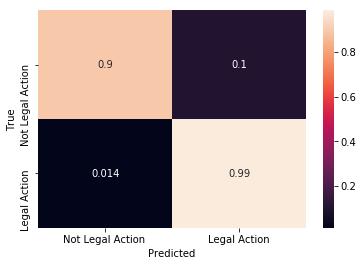

In [15]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "Not Legal Action ", "Legal Action"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(train_df["LegalAction"], 
                           get_predictions(estimator, predict_train_input_fn))
    
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

### Transfer Learning 

In [175]:
def train_and_evaluate_with_module(hub_module, train_module=False):
    embedded_text_feature_column = hub.text_embedding_column(
        key="Sentence", module_spec=hub_module, trainable=train_module)

    estimator = tf.estimator.DNNClassifier(
        hidden_units=[500, 100],
        feature_columns=[embedded_text_feature_column],
        n_classes=2,
        optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

    estimator.train(input_fn=train_input_fn, steps=100)

    train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

    training_set_accuracy = train_eval_result["accuracy"]
    test_set_accuracy = test_eval_result["accuracy"]

    return {
        "Training accuracy": training_set_accuracy,
        "Test accuracy": test_set_accuracy
    }


results = {}
#results["nnlm-en-dim128"] = train_and_evaluate_with_module(
#    "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["universal-sentence-encoder-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/universal-sentence-encoder/2",True)
#results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
#    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_master': '', '_task_id': 0, '_evaluation_master': '', '_model_dir': '/tmp/tmpkf5mj3g1', '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8836b36400>, '_tf_random_seed': None, '_train_distribute': None, '_save_checkpoints_steps': None, '_service': None, '_is_chief': True, '_num_worker_replicas': 1, '_device_fn': None, '_global_id_in_cluster': 0, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was

In [176]:
pd.DataFrame.from_dict(results, orient="index")

Test accuracy  \
nnlm-en-dim128-with-module-training                   0.924725   
universal-sentence-encoder-with-module-training       0.955129   

                                                 Training accuracy  
nnlm-en-dim128-with-module-training                       0.925036  
universal-sentence-encoder-with-module-training           0.956060

In [5]:
def upsample_rare(data, Rare_ColStr):
    '''
    Input: {'data':'dataframe with rare event','Rare_ColStr':'name of the column containing the rare target event we want to oversample'
    Output: Dataframe of equal proportions of target event to be used only in training (MUST SPLIT TEST DATA SET BEFORE RUNNING THIS)

    '''
    negobs = data[data[Rare_ColStr]==False]
    posobs = data[data[Rare_ColStr]==True]

    #create a list of dataframes, where each data frame contains a replica of all postive observations which we can use for oversampling 
    rep_1 =[posobs for x in range(negobs.shape[0]//posobs.shape[0] )]
    keep_1s = pd.concat(rep_1, axis=0)
    train_dat = pd.concat([keep_1s,negobs],axis=0)
    return(train_dat)   